In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

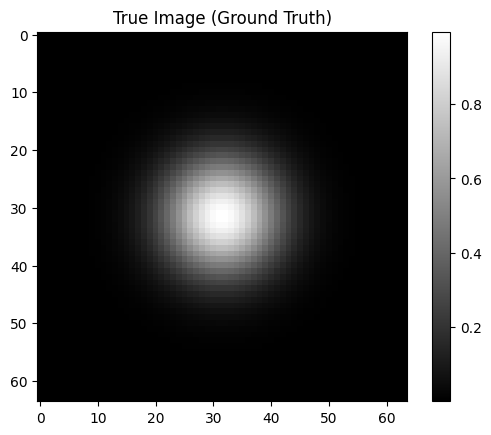

In [35]:
# Create a synthetic "true image" - A circle in a 64x64 grid
def generate_true_image(size=64):
    x, y = np.meshgrid(np.linspace(-1, 1, size), np.linspace(-1, 1, size))
    true_image = np.exp(-10 * (x**2 + y**2))  # Creates a Gaussian-like blob
    return true_image

# Generate and visualize the true image
true_image = generate_true_image()

plt.imshow(true_image, cmap='gray')
plt.title("True Image (Ground Truth)")
plt.colorbar()
plt.show()

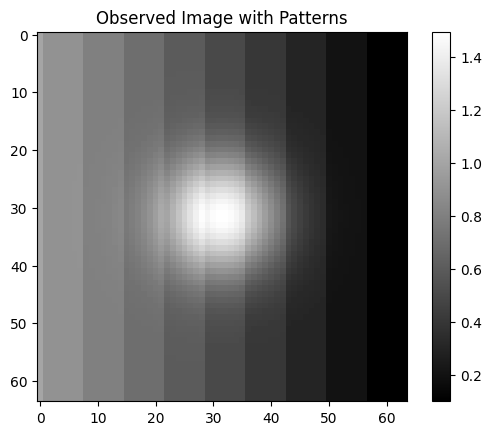

In [36]:
# Step 2: Initialize with noisy version of true image
def generate_scale_bar(size=64, num_levels=10):
    """
    Generate a gradient layer with high values at the top and low values at the bottom.
    The gradient is discretized into a specified number of levels to create visible steps.
    """
    # Create a linear gradient from high to low
    scale_layer = np.linspace(1, 0, size)  # Linear gradient from 1 to 0
    scale_layer = np.tile(scale_layer, (size, 1))  # Repeat to create 2D layer
    # Discretize the gradient into `num_levels` discrete steps
    scale_layer_discrete = np.digitize(scale_layer, bins=np.linspace(0, 1, num_levels))  # Bin values into levels
    # Normalize back to a range [0, 1] (if needed for visual consistency)
    scale_layer_discrete = scale_layer_discrete / num_levels
    
    return scale_layer_discrete

obs_image = true_image + generate_scale_bar()

# Visualize the noisy image
plt.imshow(obs_image, cmap="gray")
plt.title("Observed Image with Patterns")
plt.colorbar()
plt.show()

In [33]:
# Step 3: Variational Inference (VI) Setup
sigma = 0.1  # Noise level
prior_sigma = 1.0  # Prior strength

# Log-likelihood (Gaussian)
def log_likelihood(image):
    """Assume Gaussian likelihood centered around the true image."""
    return -np.sum((image - true_image) ** 2) / (2 * sigma**2)

# Log-prior (Gaussian)
def log_prior(image):
    """Assume Gaussian prior favoring smaller pixel values."""
    return -np.sum(image**2) / (2 * prior_sigma**2)

# ELBO Function
def elbo(image, true_image=true_image, sigma=sigma, prior_sigma=prior_sigma):
    """Calculate the Evidence Lower Bound (ELBO) for Variational Inference."""
    # Reshape the flattened image to match the shape of the true image
    image_reshaped = image.reshape(true_image.shape)
    return -(log_likelihood(image_reshaped) + log_prior(image_reshaped))

In [37]:
# Optimization Step
def variational_inference(initial_image, num_steps=500):
    """Run variational inference to approximate the posterior."""
    # We minimize the ELBO (equivalently, maximize the negative ELBO)
    result = minimize(elbo, initial_image.flatten(), args=(true_image,), method='L-BFGS-B', 
                      options={'maxiter': num_steps}, bounds=[(0, 1)] * initial_image.size)
    # Reshape the result back to the image shape
    return result.x.reshape(initial_image.shape)
# Perform variational inference on the noisy image
reconstructed_image = variational_inference(obs_image)

In [39]:
# Step 4: Compute the uncertainty (posterior variance)
def sampling(image, true_image=true_image, sigma=sigma, prior_sigma=prior_sigma, num_samples=10):
    """Estimate the posterior variance by sampling multiple times."""
    samples = np.zeros((num_samples, *image.shape))
    for i in range(num_samples):
        samples[i] = variational_inference(image)
    return samples

# Estimate the posterior variance (uncertainty) for the reconstructed image
samples = sampling(obs_image)

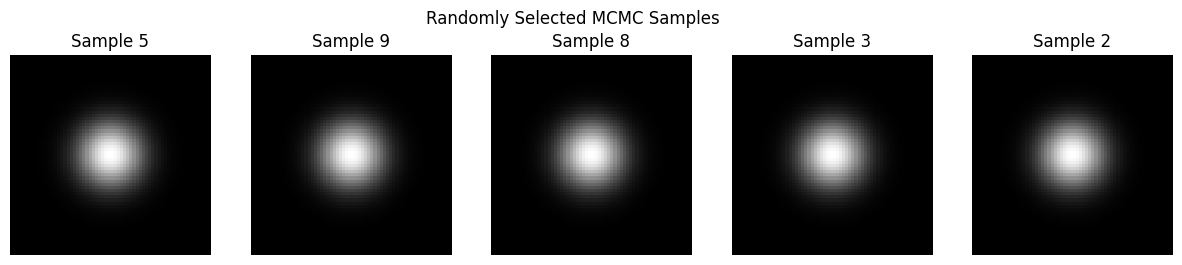

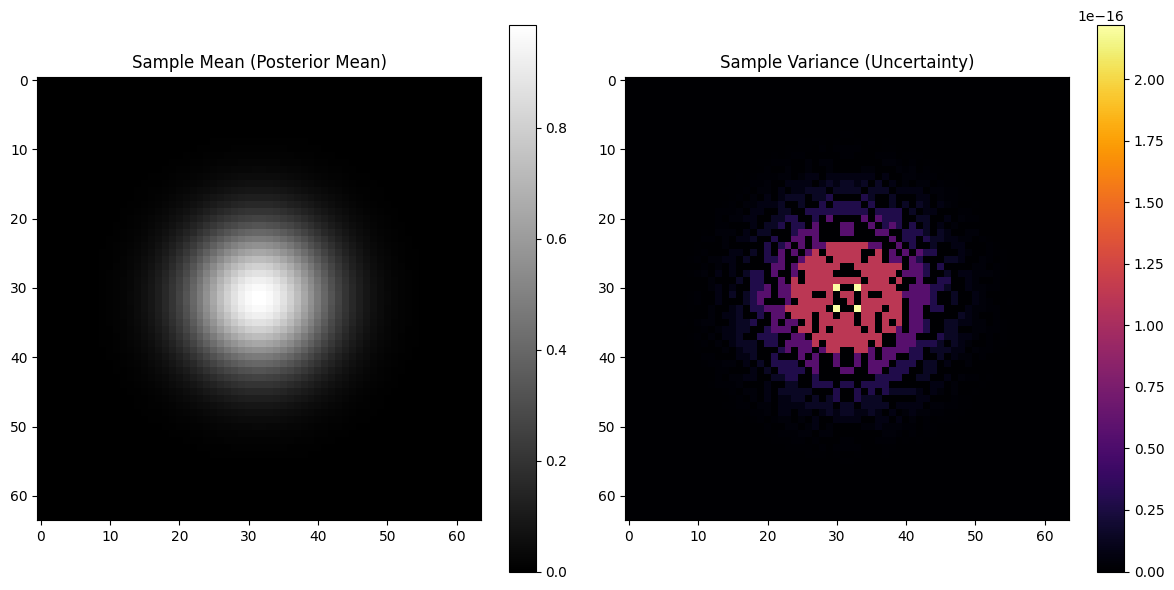

In [40]:

# Step 6: Visualization


# Select random samples to visualize
num_visualize = 5
random_indices = np.random.choice(len(samples), num_visualize, replace=False)

plt.figure(figsize=(15, 3))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_visualize, i + 1)
    plt.imshow(samples[idx], cmap="gray")
    plt.axis("off")
    plt.title(f"Sample {idx}")
plt.suptitle("Randomly Selected MCMC Samples")
plt.show()

# Compute sample mean and variance
sample_mean = np.mean(samples, axis=0)
sample_std = np.std(samples, axis=0)


plt.figure(figsize=(12, 6))
# Plot sample mean
plt.subplot(1, 2, 1)  
plt.imshow(sample_mean, cmap="gray")
plt.colorbar()
plt.title("Sample Mean (Posterior Mean)")

# Plot sample variance
plt.subplot(1, 2, 2) 
plt.imshow(sample_std, cmap="inferno")
plt.colorbar()
plt.title("Sample Variance (Uncertainty)")

# Show both plots
plt.tight_layout()
plt.show()